## Two-Stage Training Methodology for Super-Linear

This section illustrates the **two-stage training strategy** for Super-Linear using synthetic frequency data:

1. **Phase 1 – Expert Training**  
   Train the linear experts independently to capture frequency-specific patterns.

2. **Phase 2 – Router Training**  
   Freeze the experts and train only the router to learn how to combine them effectively.

Finally, we **visualize the results** to demonstrate how the experts and router collaborate.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


In [2]:
class RLinear(nn.Module):
    def __init__(self, input_len, output_len):
        super().__init__()
        self.linear = nn.Linear(input_len, output_len)
        self.norm = nn.InstanceNorm1d(1, affine=False)

    def forward(self, x):
        # x: [B, L]
        x = x.unsqueeze(1)          # [B, 1, L]
        x = self.norm(x)            # [B, 1, L]
        x = x.squeeze(1)            # [B, L]

        x = self.linear(x)          # [B, Output_len]
        return x

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np



class SparseMoE(nn.Module):
    def __init__(self, seq_len, pred_len, n_experts, top_k, fft_len, noise_std):
        super().__init__()
        self.experts = nn.ModuleList([RLinear(seq_len, pred_len) for _ in range(n_experts)])
        self.num_experts = n_experts
        self.k = min(top_k, n_experts)
        self.noise_std = noise_std
        self.fft_len = fft_len
        self.gating_network = nn.Linear(self.fft_len // 2, n_experts, bias=True)

    def get_periodogram(self, x, n):
        x = x - torch.mean(x, dim=1, keepdim=True)
        dft = torch.fft.fft(x, dim=1, n=n) / np.sqrt(n)
        dft = dft[:, :n // 2]
        I = torch.abs(dft) ** 2
        I_sum = torch.sum(I, dim=1, keepdim=True)
        I_sum[I_sum == 0] = 1
        return I / I_sum

    def forward(self, x):
        x_spec = self.get_periodogram(x, n=self.fft_len)
        gate_outputs = self.gating_network(x_spec)
        if self.noise_std > 0 and self.training:
            noise = torch.randn_like(gate_outputs) * self.noise_std
            gate_outputs = gate_outputs + noise
        topk_values, topk_indices = torch.topk(gate_outputs, self.k, dim=1)
        topk_gates = F.softmax(topk_values, dim=1)

        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        topk_indices_exp = topk_indices.unsqueeze(-1).expand(-1, -1, expert_outputs.size(2))
        sparse_outputs = torch.gather(expert_outputs, 1, topk_indices_exp)

        return torch.sum(topk_gates.unsqueeze(2) * sparse_outputs, dim=1)


class SuperLinearMini(nn.Module):
    def __init__(self, seq_len, pred_len, n_experts, top_k, fft_len, noise_std = 0.1):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.noise_std = noise_std
        self.moe = SparseMoE(seq_len, pred_len, n_experts, top_k, fft_len, noise_std = noise_std)

    def freeze_experts(self):
        for param in self.moe.experts.parameters():
            param.requires_grad = False

    def forward(self, x_enc):
        if len(x_enc.shape) == 2:     # [B, L]
            x = x_enc.unsqueeze(1)    # [B, 1, L]
        else:                         # [B, L, V]
            x = x_enc.permute(0, 2, 1)
        B, V, L = x.shape
        x = x.reshape(B * V, L)

        out = self.moe(x)             # [B*V, pred_len]
        out = out.reshape(B, V, out.shape[-1]).permute(0, 2, 1)

        if len(x_enc.shape) == 2:
            out = out.squeeze(-1)
        return out


### Generate synthetic datasets for each expert

In [4]:
# Generate synthetic datasets for each expert
import numpy as np
import torch

def generate_sine_randomwalk(freq, seq_len, n_samples, sigma=0.02):
    X = []
    for _ in range(n_samples):
        phase = np.random.uniform(0, 2 * np.pi)
        t = np.arange(seq_len)
        sine = np.sin(2 * np.pi * freq * t + phase)
        rw = np.cumsum(np.random.normal(0, sigma, seq_len))
        wn = np.random.normal(0, sigma, seq_len)
        X.append(sine + rw + wn)
    return np.stack(X)

frequencies = [1/7, 1/12, 1/24, 1/48, 1/96, 1/144, 1/192, 1/288]
seq_len = 512
pred_len = 96
n_samples = 500
expert_datasets = [generate_sine_randomwalk(f, seq_len + pred_len, n_samples) for f in frequencies]
# expert_datasets is a list of arrays, one per expert

### Phase 1: Expert training

Train each linear expert on a separate frequency

In [5]:

import torch.optim as optim

SuperLinear = SuperLinearMini(  seq_len=512,
                                pred_len=96,
                                n_experts=8,
                                top_k=3,
                                fft_len=5000)


# Use the SuperLinear instance already created
experts = SuperLinear.moe.experts
seq_len = 512
pred_len = 96

for i, expert in enumerate(experts):
    data = torch.tensor(expert_datasets[i], dtype=torch.float32)  # [n_samples, seq_len+pred_len]
    X = data[:, :seq_len]
    y = data[:, seq_len:]
    optimizer = optim.Adam(expert.parameters(), lr=0.005)
    loss_fn = torch.nn.MSELoss()
    for epoch in range(100):
        optimizer.zero_grad()
        out = expert(X)
        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
    print(f"Expert {i} trained. Final loss: {loss.item():.4f}")

Expert 0 trained. Final loss: 0.0276
Expert 1 trained. Final loss: 0.0265
Expert 2 trained. Final loss: 0.0274
Expert 3 trained. Final loss: 0.0275
Expert 4 trained. Final loss: 0.0278
Expert 5 trained. Final loss: 0.0328
Expert 6 trained. Final loss: 0.0360
Expert 7 trained. Final loss: 0.0407


In [6]:
# Join all datasets into a shared dataset for full model training
all_data = np.concatenate(expert_datasets, axis=0)
np.random.shuffle(all_data)
seq_len = 512
pred_len = 96
X_all = torch.tensor(all_data[:, :seq_len], dtype=torch.float32)
y_all = torch.tensor(all_data[:, seq_len:], dtype=torch.float32)
print(f"Combined dataset shape: {X_all.shape}")

Combined dataset shape: torch.Size([4000, 512])


### Phase 2: Router training

Freeze the linear experts and train the router

In [7]:
# Freeze experts and train the full model (gating network only) on the combined dataset
SuperLinear.freeze_experts()
learning_rate_decay = 0.9
optimizer = torch.optim.Adam([p for p in SuperLinear.parameters() if p.requires_grad], lr=0.1)
loss_fn = torch.nn.MSELoss()
for epoch in range(200):
    optimizer.zero_grad()
    out = SuperLinear(X_all)
    loss = loss_fn(out, y_all)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
        # update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= learning_rate_decay

Epoch 10, Loss: 0.2876
Epoch 20, Loss: 0.0871
Epoch 30, Loss: 0.0511
Epoch 40, Loss: 0.0427
Epoch 50, Loss: 0.0394
Epoch 60, Loss: 0.0379
Epoch 70, Loss: 0.0370
Epoch 80, Loss: 0.0365
Epoch 90, Loss: 0.0360
Epoch 100, Loss: 0.0357
Epoch 110, Loss: 0.0354
Epoch 120, Loss: 0.0351
Epoch 130, Loss: 0.0350
Epoch 140, Loss: 0.0348
Epoch 150, Loss: 0.0346
Epoch 160, Loss: 0.0346
Epoch 170, Loss: 0.0344
Epoch 180, Loss: 0.0343
Epoch 190, Loss: 0.0342
Epoch 200, Loss: 0.0341


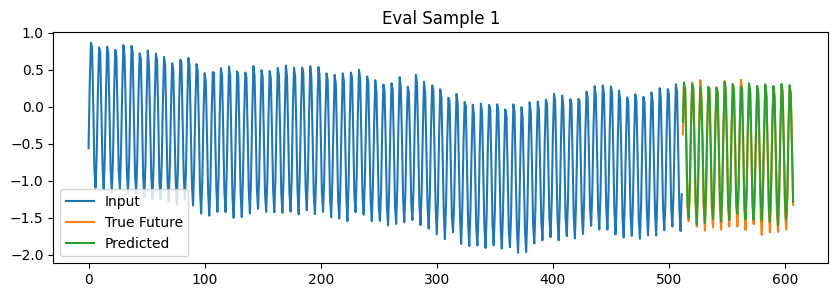

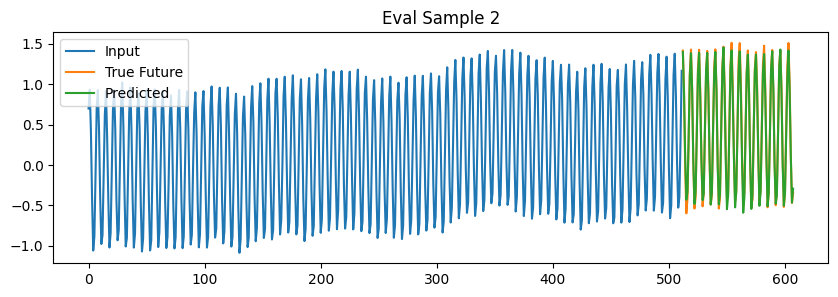

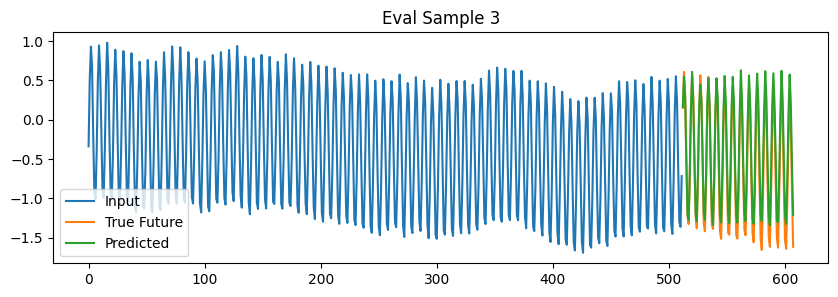

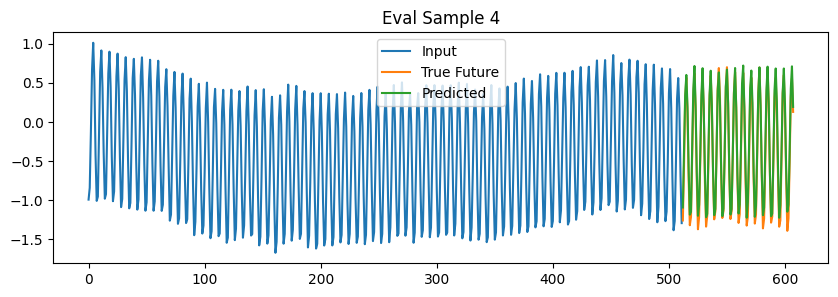

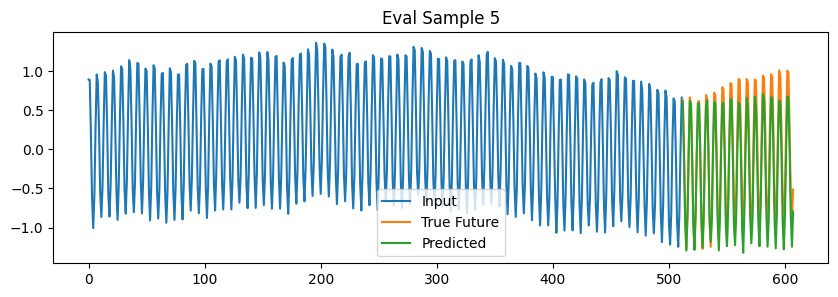

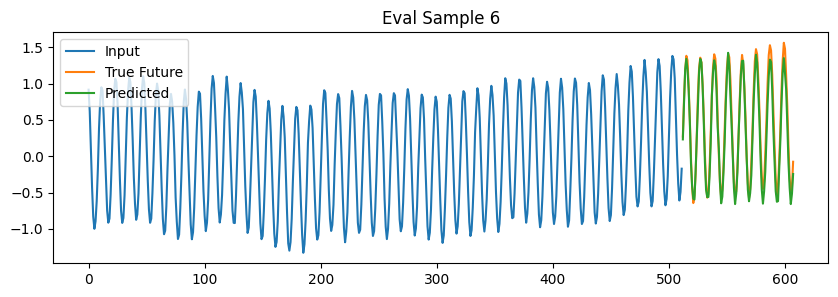

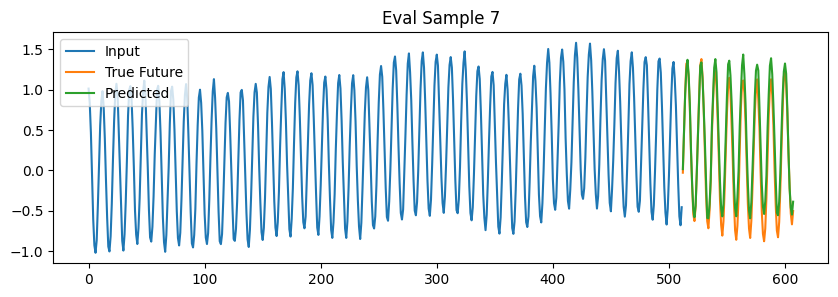

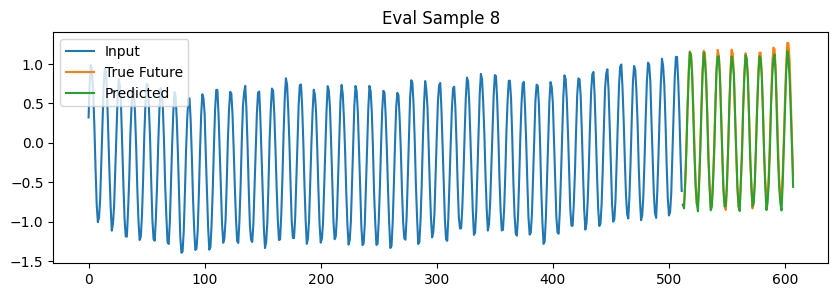

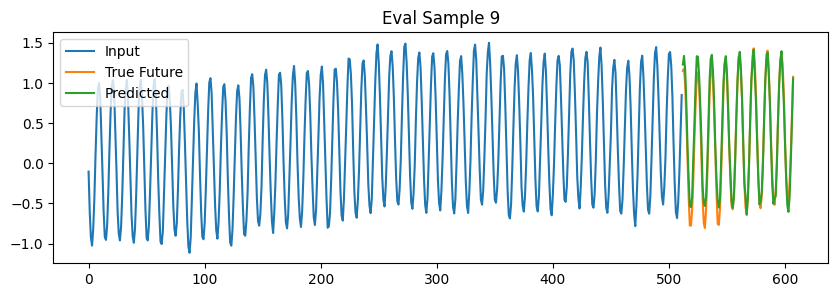

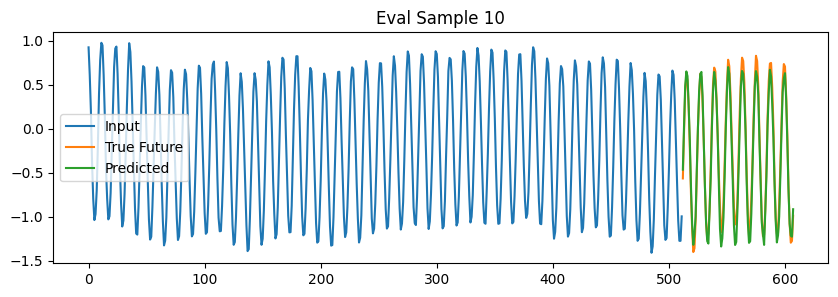

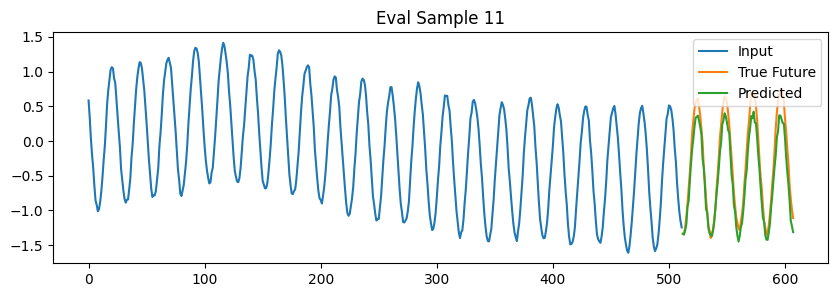

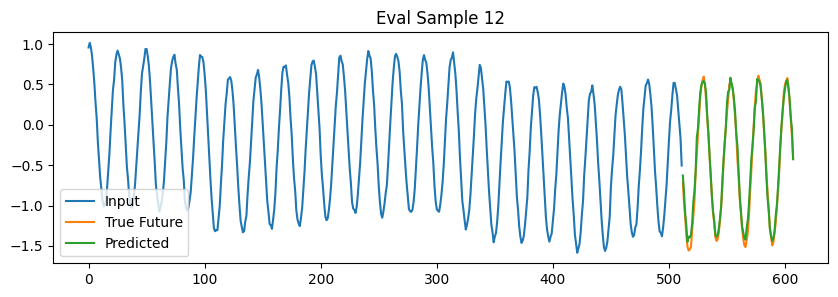

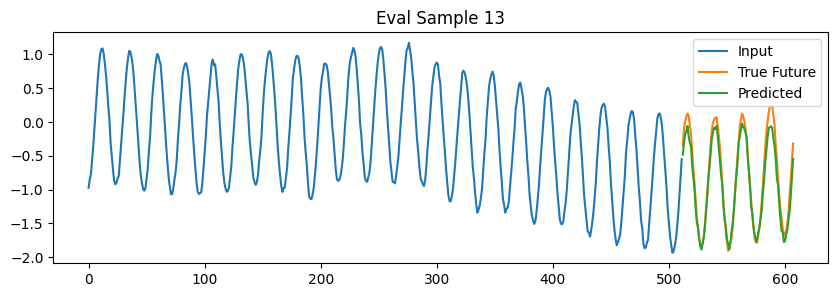

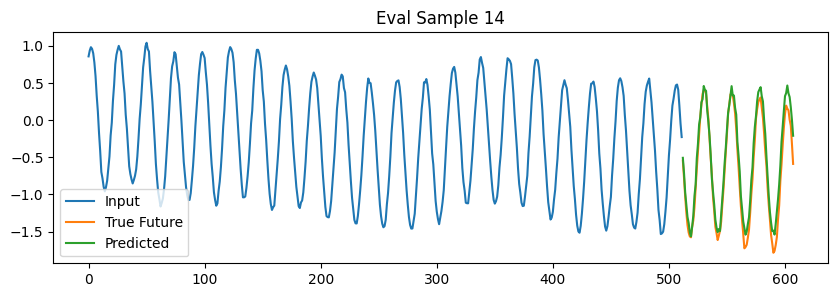

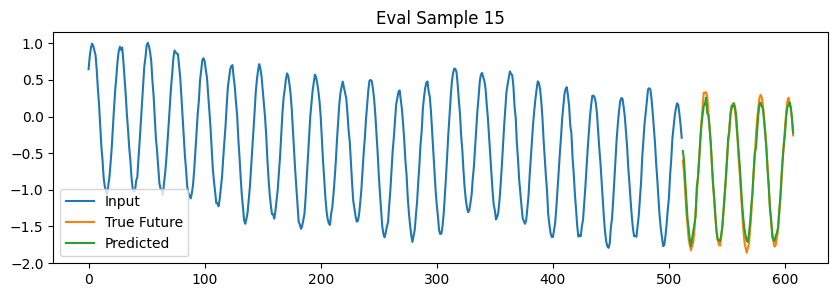

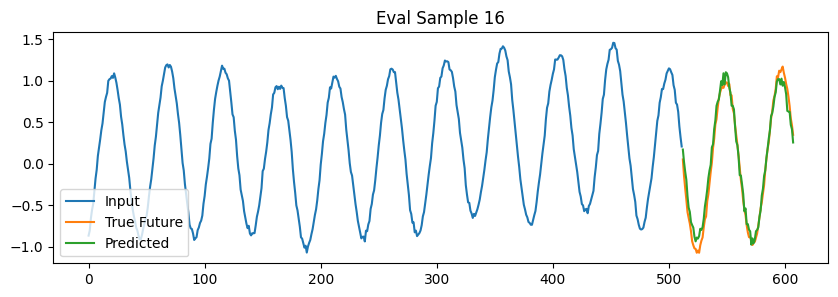

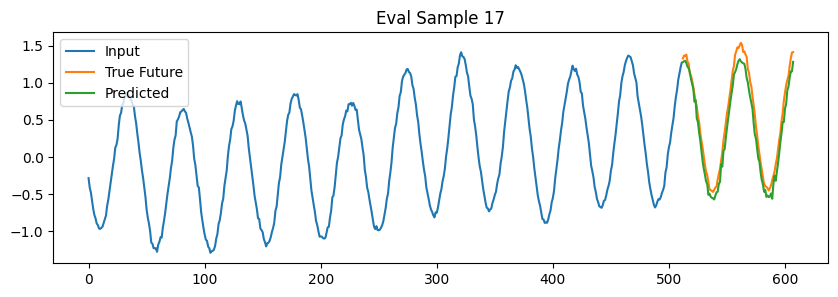

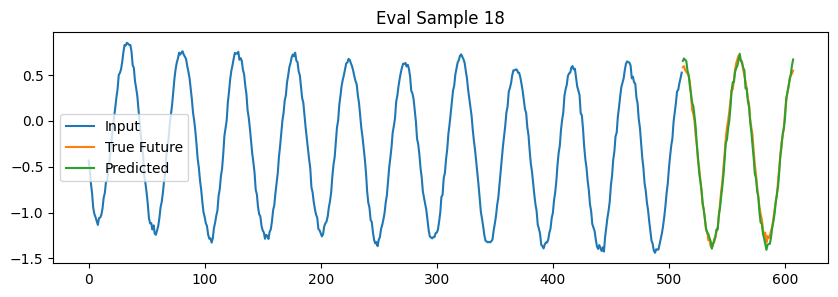

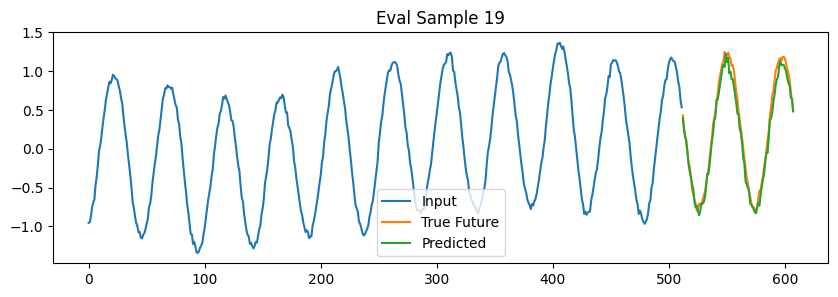

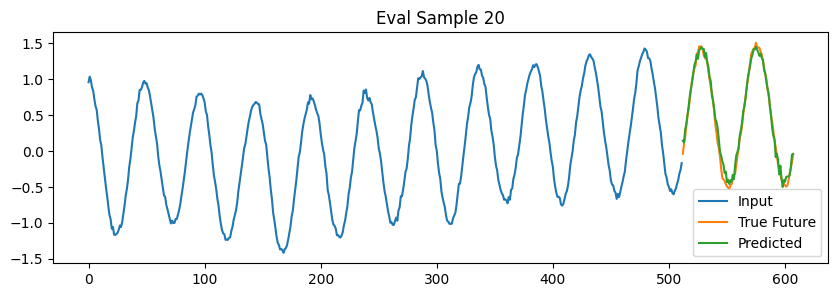

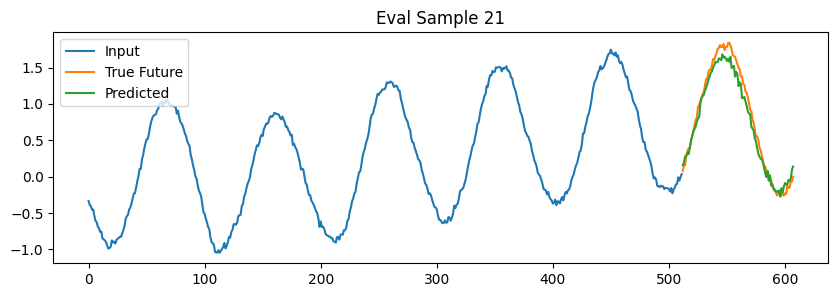

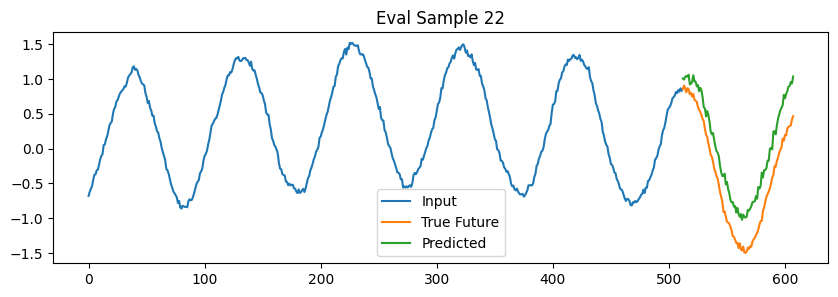

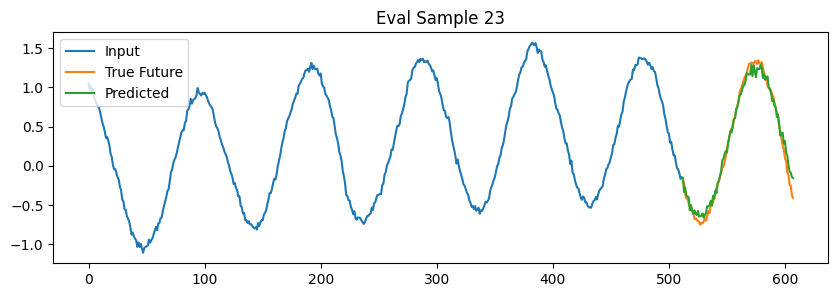

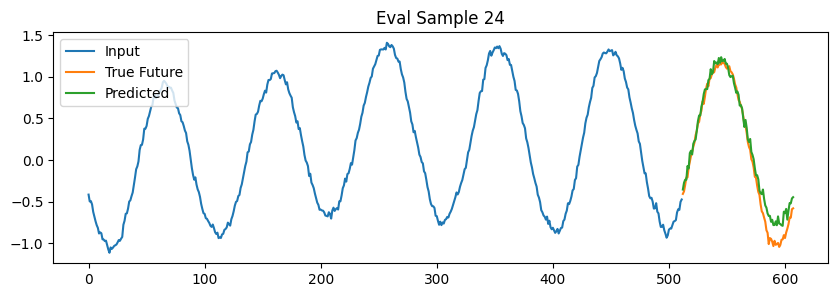

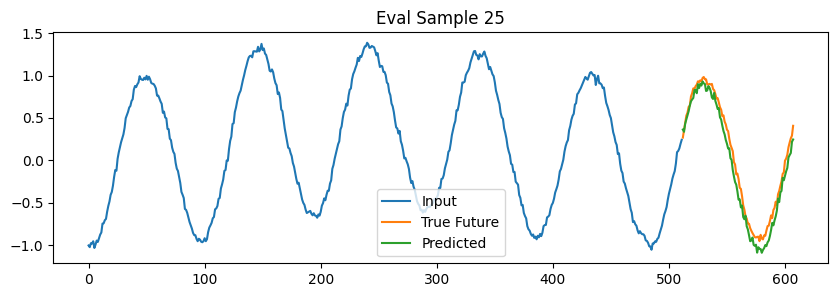

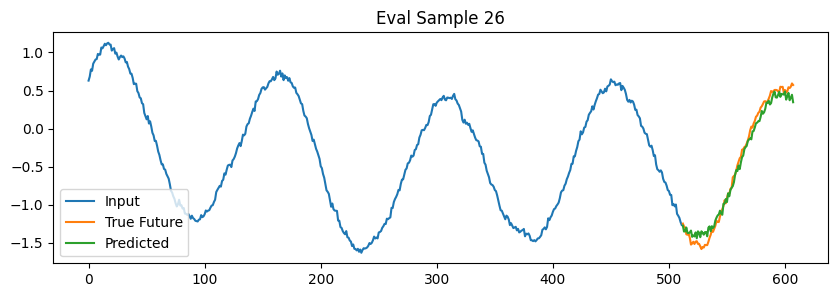

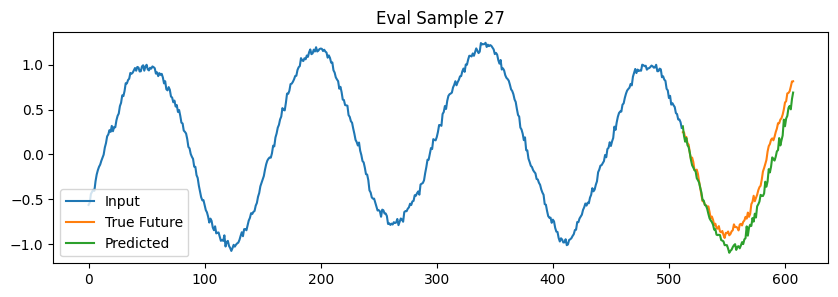

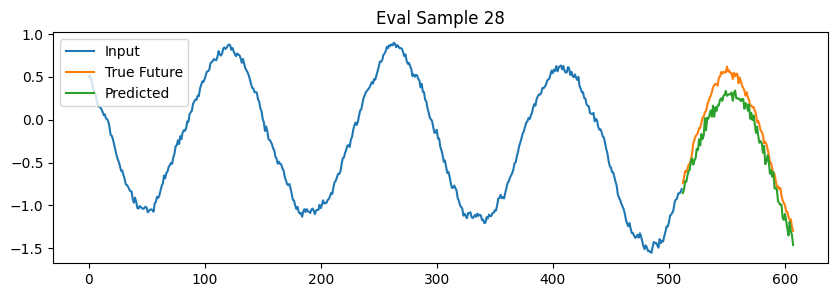

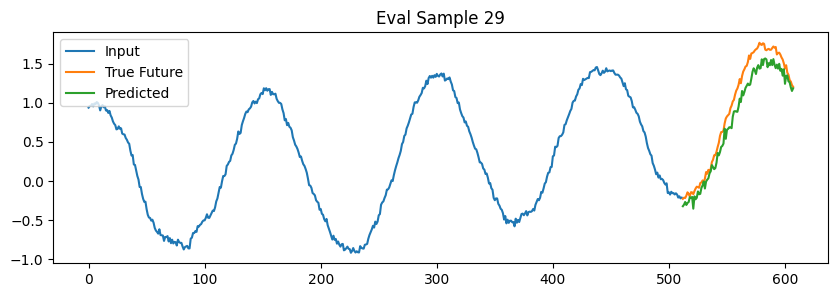

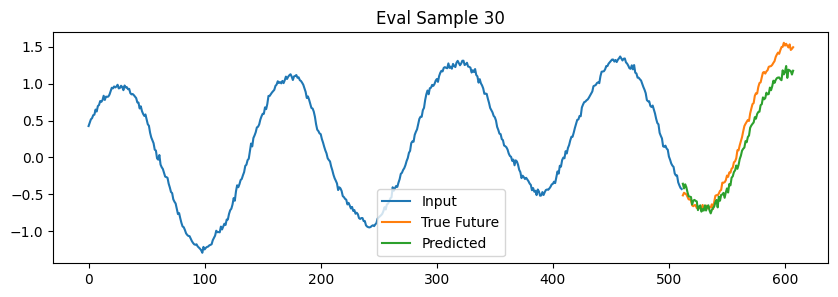

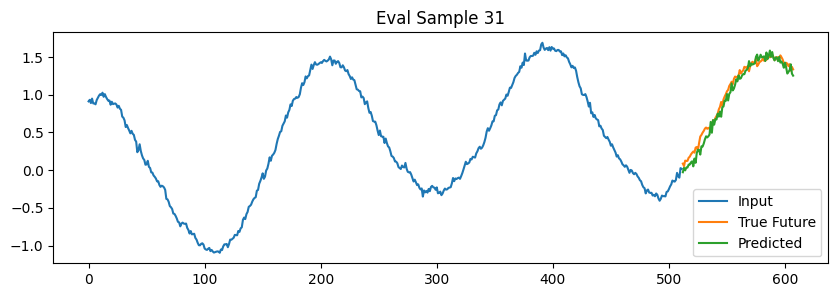

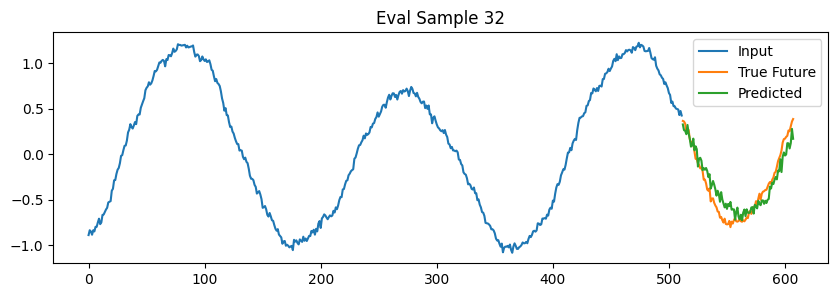

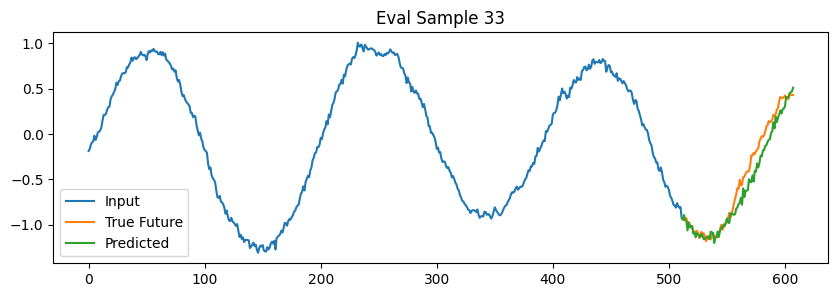

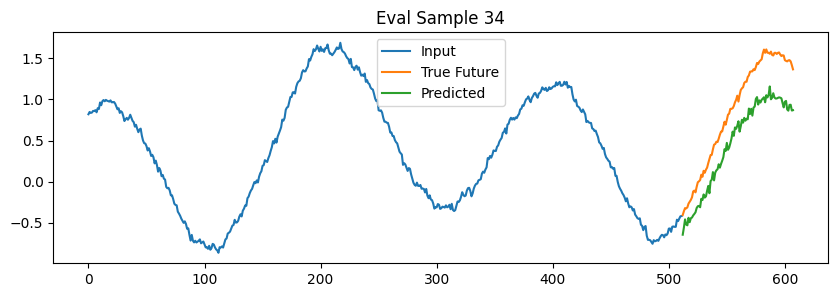

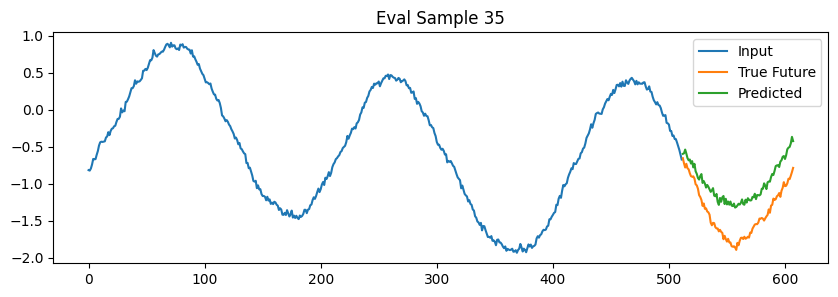

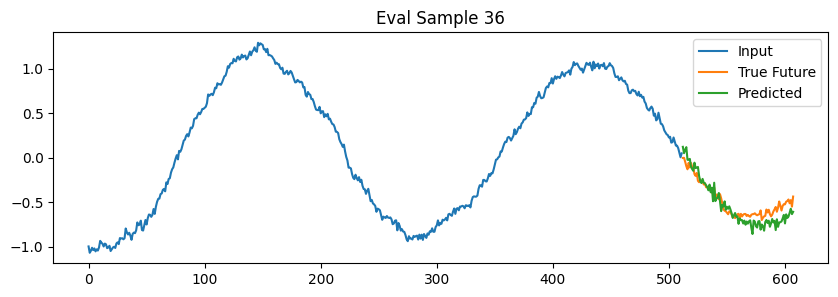

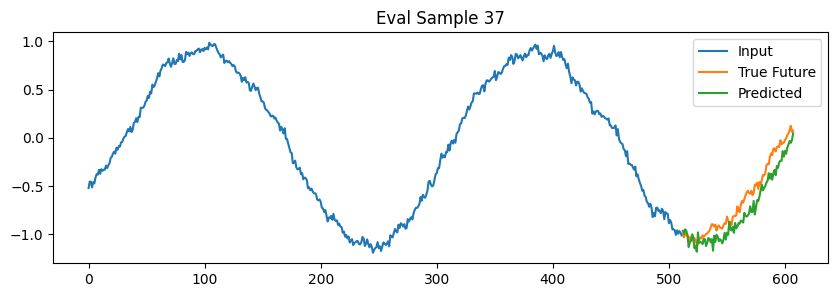

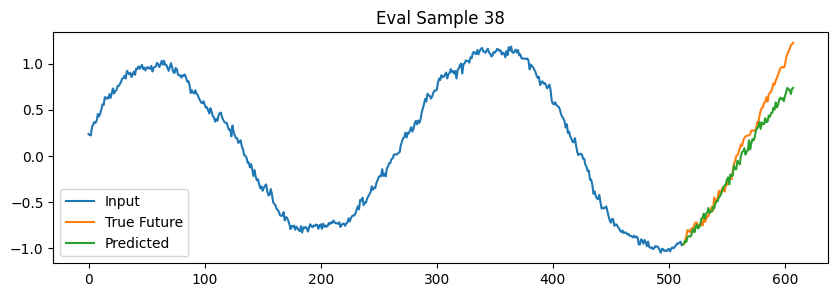

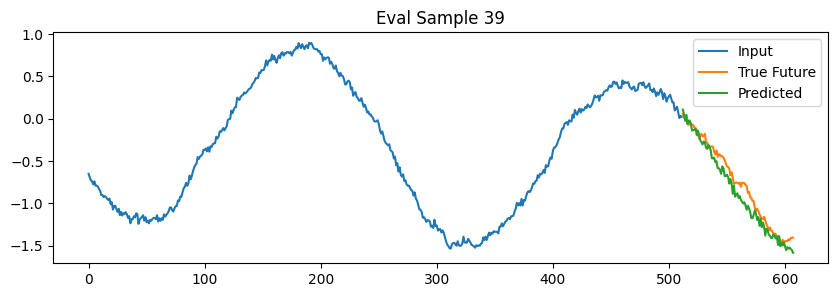

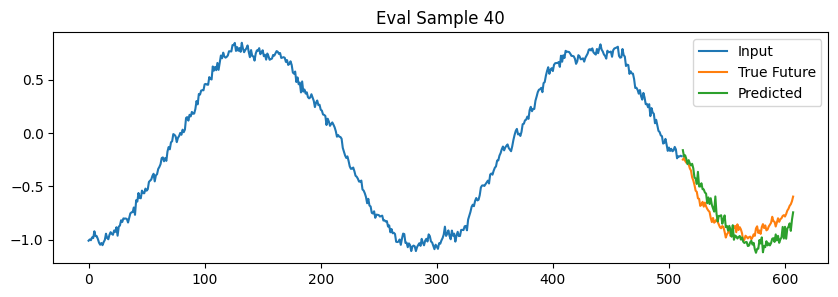

In [8]:
# Generate new data and plot predictions from the trained model vs ground truth
import matplotlib.pyplot as plt

# Generate new synthetic evaluation data (one per frequency)
eval_n_samples = 5
eval_datasets = [generate_sine_randomwalk(f, seq_len + pred_len, eval_n_samples) for f in frequencies]
eval_data = np.concatenate(eval_datasets, axis=0)
X_eval = torch.tensor(eval_data[:, :seq_len], dtype=torch.float32)
y_eval = torch.tensor(eval_data[:, seq_len:], dtype=torch.float32)

SuperLinear.eval()
with torch.no_grad():
    y_pred = SuperLinear(X_eval)

for i in range(len(X_eval)):
    plt.figure(figsize=(10,3))
    plt.plot(np.arange(seq_len), X_eval[i].numpy(), label='Input')
    plt.plot(np.arange(seq_len, seq_len+pred_len), y_eval[i].numpy(), label='True Future')
    plt.plot(np.arange(seq_len, seq_len+pred_len), y_pred[i].numpy(), label='Predicted')
    plt.legend()
    plt.title(f"Eval Sample {i+1}")
    plt.show()